In [1]:
import pandas as pd
import ast
import re
import dimcli

In [13]:
def wrangle_rolling(timestamp, fname):
    import re, ast
    import pandas as pd

    def extract_for_code(name):
        if isinstance(name, str):
            match = re.match(r"^(\d{6}|\d{4}|\d{2})\b", name)
            if match:
                code = match.group(1)
                level = f"L{len(code)}"
                return pd.Series([code, level])
        return pd.Series([None, None])
    
    def extract_label(name):
        if isinstance(name, str):
            return re.sub(r"^\d{2} |\d{4} |\d{6} ", "", name)
        return None
        
    def safe_parse(x):
        try:
            if isinstance(x, str):
                return ast.literal_eval(x)
            elif x is None or (isinstance(x, float) and pd.isna(x)):
                return []
            return x  # already list
        except:
            return []
    
    df = pd.read_excel(f'../data/dimensions/api/raw/combined/{timestamp}/{fname}',
                       index_col=0)
    
    df['date'] = pd.to_datetime(df['date'])
    date_counts = df['date'].value_counts().sort_index()
    date_counts_df = date_counts.rename_axis('date').reset_index(name='count')
    date_counts_df.set_index('date', inplace=True)
    daily_counts = date_counts_df['count'].resample('D').sum()
    rolling_counts = daily_counts.rolling(window='180D').sum()
    rolling_df = rolling_counts.reset_index()
    
    df['category_for_2020'] = df['category_for_2020'].apply(safe_parse)
    df = df[df['category_for_2020'].apply(lambda x: bool(x))]
    df_exploded = df.explode('category_for_2020', ignore_index=True)
    df_exploded = df_exploded[df_exploded['category_for_2020'].notnull()]
    category_df = pd.json_normalize(df_exploded['category_for_2020'])
    df_result = pd.concat([df_exploded['date'], category_df], axis=1)
    df_result = df_result.rename(columns={'id': 'category_id', 'name': 'category_name'})
    df_result['category_label'] = df_result['category_name'].apply(extract_label)
    df_result[['FoR', 'L']] = df_result['category_name'].apply(extract_for_code)
    
    # Compute the subset corresponding to level "L2"
    df_L2 = df_result[df_result['L'] == 'L2']
    L2_counts = df_L2.groupby('category_label').size().reset_index(name='count')
    L2_counts = L2_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
    top4 = L2_counts.iloc[:4].copy()
    rest = L2_counts.iloc[4:]
    other_total = rest['count'].sum()
    other_row = pd.DataFrame([{'category_label': 'Other', 'count': other_total}])
    L2_counts_grouped = pd.concat([top4, other_row], ignore_index=True)
    new_order = [0, 3, 1, 2, 4]  # reordering indices as required
    L2_counts_grouped = L2_counts_grouped.iloc[new_order].reset_index(drop=True)
    
    print(L2_counts.set_index('category_label'))    
    return L2_counts_grouped, rolling_df, df_L2  # Return df_L2 as well

# Unpack the three returned values
L2_counts_grouped, rolling_df, df_L2 = wrangle_rolling('202511', 'df_dimensions.xlsx')

                                            count
category_label                                   
Biomedical and Clinical Sciences             6553
Health Sciences                              3926
Biological Sciences                          2420
Psychology                                    979
Mathematical Sciences                         266
Environmental Sciences                        152
Information and Computing Sciences            148
Engineering                                    90
Chemical Sciences                              51
Human Society                                  44
Agricultural, Veterinary and Food Sciences     34
Physical Sciences                              22
Economics                                      13
Commerce, Management, Tourism and Services     11
History, Heritage and Archaeology              10
Earth Sciences                                  7
Built Environment and Design                    6
Education                                       2


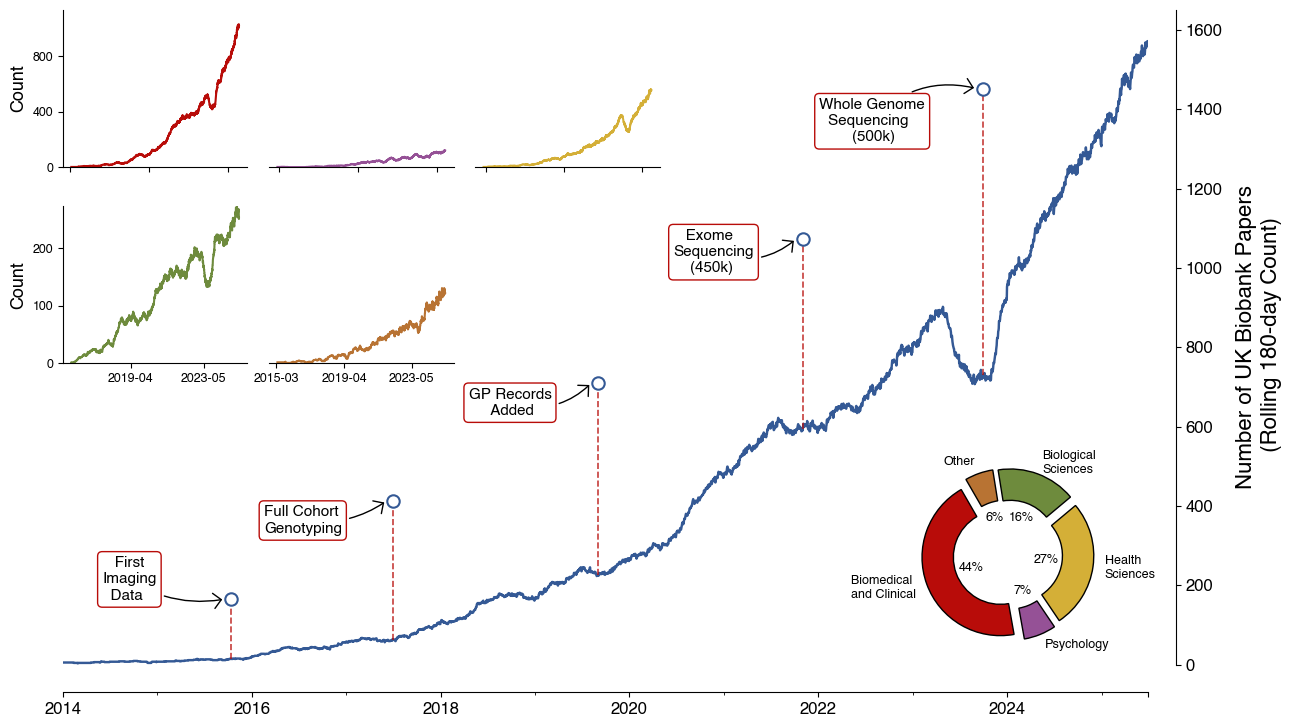

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams['font.family'] = 'Helvetica'

main_series = rolling_df[:-125].set_index('date')['count'].rolling('180D').sum()
main_series = main_series.dropna()  # Remove early NaNs from rolling window

# Function to get normalized ymin (as a fraction of axis height)
def get_normalized_ymin(date):
    date = pd.to_datetime(date)
    y_val = main_series.reindex(main_series.index.union([date])).interpolate(method='time').loc[date]
    y_max = ax.get_ylim()[1]
    return y_val / y_max

# === Custom Regal Color Palette ===
colors_dict = {
    "main": "#345995",       # Royal Blue
    "category_1": "#B80C09",   # Crimson Red
    "category_2": "#955196",   # Antique Gold
    "category_3": "#D4AF37",   # Soft Plum
    "category_4": "#6E8B3D",   # Olive Green
    "category_5": "#3C4CAD",   # Indigo Blue
    "other": "#B87333",        # Copper
}

fig, ax = plt.subplots(1, 1, figsize=(14, 8.5))
lw = 1.5

# === Main plot ===
rolling_df[138:-125].set_index('date').plot(ax=ax, color=colors_dict["main"], linewidth=lw+.25)
ax.set_axisbelow(False)
#ax.grid(True, axis='both', linestyle=(0, (2, 6)), linewidth=0.74, alpha=0.3, color='k', zorder=3)
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
ax.set_ylabel("Number of UK Biobank Papers\n (Rolling 180-day Count)", labelpad=10, fontsize=16)
ax.legend().set_visible(False)

# === Inset layout settings ===
inset_width = 0.17
inset_height = 0.24
h_spacing = 0.02
v_spacing = 0.06

top4_labels = L2_counts_grouped['category_label'].tolist()

top_row_axes = []
top_row_ys = []
bottom_row_axes = []
bottom_row_ys = []

for idx in range(5):
    row = 0 if idx < 3 else 1
    col = idx % 3

    left = col * (inset_width + h_spacing)
    bottom = 1 - (row + 1) * inset_height - row * v_spacing

    inset_ax = ax.inset_axes([left, bottom, inset_width, inset_height], zorder=2)
    label = top4_labels[idx]

    if label != "Other":
        df_subset = df_L2[df_L2['category_label'] == label].copy()
        color = colors_dict[f"category_{idx + 1}"]
    else:
        df_subset = df_L2[~df_L2['category_label'].isin(top4_labels)].copy()
        color = colors_dict["other"]

    df_subset['date'] = pd.to_datetime(df_subset['date'])
    ts = df_subset.groupby('date').size().sort_index()
    ts = ts.asfreq('D', fill_value=0)
    ts = ts[:-125]
    ts_rolling = ts.rolling('180D').sum()

    inset_ax.plot(ts_rolling.index, ts_rolling.values, lw=lw, color=color)

    for spine in inset_ax.spines.values():
        spine.set_visible(False)
    inset_ax.spines['bottom'].set_visible(True)
    if col == 0:
        inset_ax.spines['left'].set_visible(True)

    if col == 0:
        inset_ax.tick_params(axis='y', labelsize=9)
        inset_ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        inset_ax.set_ylabel("Count", fontsize=13)
    else:
        inset_ax.set_yticks([])

    inset_ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    inset_ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    if row == 0:
        inset_ax.set_xticklabels([])
    else:
        inset_ax.tick_params(axis='x', labelsize=9)

    if row == 0:
        top_row_axes.append(inset_ax)
        top_row_ys.append(ts_rolling.max())
        inset_ax.spines['top'].set_visible(False)
    else:
        bottom_row_axes.append(inset_ax)
        bottom_row_ys.append(ts_rolling.max())

def sync_y_axes(axes, ymax):
    for ax in axes:
        ax.set_ylim(0, ymax)

sync_y_axes(top_row_axes, ymax=max(top_row_ys) * 1.1)
sync_y_axes(bottom_row_axes, ymax=max(bottom_row_ys))

# === Doughnut pie chart ===
raw_labels = L2_counts_grouped['category_label'].tolist()
sizes = L2_counts_grouped['count'].tolist()

def clean_label(lbl):
    if lbl == "Biomedical and Clinical Sciences":
        return "Biomedical \nand Clinical"
    elif lbl == "Health Sciences":
        return "Health\nSciences"
    elif lbl == "Biological Sciences":
        return "Biological\nSciences"
    else:
        return lbl

labels = [clean_label(lbl) for lbl in raw_labels]

label_to_color = {}
for i, raw_lbl in enumerate(raw_labels):
    clean_lbl = clean_label(raw_lbl)
    if clean_lbl == "Other":
        label_to_color[clean_lbl] = colors_dict["other"]
    elif i < 5:
        label_to_color[clean_lbl] = colors_dict[f"category_{i+1}"]
    else:
        label_to_color[clean_lbl] = colors_dict["other"]

# Use mapping to assign pie chart colors
pie_colors = [label_to_color.get(lbl, colors_dict["other"]) for lbl in labels]
explode = [0.1] * len(labels)

pie_ax = fig.add_axes([0.71, 0.13, 0.18, 0.22])

wedges, texts, autotexts = pie_ax.pie(
    sizes,
    labels=labels,
    autopct='%1.0f%%',
    pctdistance=0.4,
    startangle=120,
    labeldistance=1.15,
    explode=explode,
    colors=pie_colors,
    textprops={'fontsize': 9},
    wedgeprops={'width': 0.4, 'edgecolor': 'black', 'linewidth': 1}
)

centre_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=0)
pie_ax.add_artist(centre_circle)
pie_ax.axis('equal')
pie_ax.set_title("")
ax.set_xlabel('')

# First Imaging Data Release — October 2015
date_imaging = pd.to_datetime("2015-10-15")
ymin = get_normalized_ymin(date_imaging)
ymin = rolling_df.loc[rolling_df['date'] == pd.to_datetime("2015-10-15"), 'count'].values[0] / ax.get_ylim()[1]
ax.axvline(date_imaging, ymin=ymin, ymax=0.11,
           color=colors_dict['category_1'], linestyle='--', linewidth=1.2, alpha=0.8)
ax.scatter(
    date_imaging,
    ax.get_ylim()[1] * 0.1,
    s=80,
    facecolors='white',
    edgecolors=colors_dict['main'],
    linewidth=1.5,
    marker='o',
    zorder=5
)
ax.annotate(
    "   First\nImaging\n  Data",
    xy=(date_imaging - pd.Timedelta(days=25), ax.get_ylim()[1] * 0.1),
    xytext=(date_imaging - pd.Timedelta(days=500), ax.get_ylim()[1] * 0.13),
    textcoords='data',
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors_dict['category_1'], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=.5,head_width=.5',
        color='k',
        connectionstyle="arc3,rad=0.2",
        lw=1
    )
)

# Full Cohort Genotyping Data — July 2017
date_geno = pd.to_datetime("2017-07-01")
ymin = rolling_df.loc[rolling_df['date'] == pd.to_datetime("2017-07-01"), 'count'].values[0] / ax.get_ylim()[1]
ax.axvline(date_geno, ymin=ymin, ymax=0.25,
           color=colors_dict['category_1'], linestyle='--', linewidth=1.2, alpha=0.8)
ax.scatter(
    date_geno,
    ax.get_ylim()[1] * 0.25,
    s=80,
    facecolors='white',
    edgecolors=colors_dict['main'],
    linewidth=1.5,
    marker='o',
    zorder=5
)
ax.annotate(
    "Full Cohort\nGenotyping",
    xy=(date_geno - pd.Timedelta(days=25), ax.get_ylim()[1] * 0.25),
    xytext=(date_geno - pd.Timedelta(days=500), ax.get_ylim()[1] * 0.22),
    textcoords='data',
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors_dict['category_1'], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=.5,head_width=.5',
        color='k',
        connectionstyle="arc3,rad=0.2",
        lw=1
    )
)

# GP Records — September 2019
date_gp = pd.to_datetime("2019-09-01")
ymin = rolling_df.loc[rolling_df['date'] == pd.to_datetime("2019-09-01"), 'count'].values[0] / ax.get_ylim()[1]
ax.axvline(date_gp, ymax=0.43, ymin=ymin, color=colors_dict['category_1'], linestyle='--', linewidth=1.2, alpha=0.8)
ax.scatter(
    date_gp,
    ax.get_ylim()[1] * 0.43,
    s=80,
    facecolors='white',
    edgecolors=colors_dict['main'],
    linewidth=1.5,
    marker='o',
    zorder=5
)
ax.annotate(
    "GP Records\n     Added",
    xy=(date_gp - pd.Timedelta(days=25), ax.get_ylim()[1] * 0.43),
    xytext=(date_gp - pd.Timedelta(days=500), ax.get_ylim()[1] * 0.4),
    textcoords='data',
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors_dict['category_1'], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=.5,head_width=.5',
        color='k',
        connectionstyle="arc3,rad=0.3",
        lw=1
    )
)

# Exome Seq (450k) — November 2021
date_exome_450k = pd.to_datetime("2021-11-01")
ymin = rolling_df.loc[rolling_df['date'] == pd.to_datetime("2021-11-01"), 'count'].values[0] / ax.get_ylim()[1]
ax.axvline(date_exome_450k, ymin=ymin, ymax=0.65, color=colors_dict['category_1'], linestyle='--', linewidth=1.2, alpha=0.8)
ax.scatter(
    date_exome_450k,
    ax.get_ylim()[1] * 0.65,
    s=80,
    facecolors='white',
    edgecolors=colors_dict['main'],
    linewidth=1.5,
    marker='o',
    zorder=5
)
ax.annotate(
    "   Exome\nSequencing\n    (450k)",
    xy=(date_exome_450k - pd.Timedelta(days=25), ax.get_ylim()[1] * 0.65),
    xytext=(date_exome_450k - pd.Timedelta(days=500), ax.get_ylim()[1] * 0.63),
    textcoords='data',
    ha='left',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors_dict['category_1'], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=0.5,head_width=0.5',
        color='k',
        connectionstyle="arc3,rad=0.3",
        lw=1
    )
)

# WGS (500k) — Late 2023 (approximate)
date_wgs = pd.to_datetime("2023-10-01")
ymin = rolling_df.loc[rolling_df['date'] == pd.to_datetime("2023-10-01"), 'count'].values[0] / ax.get_ylim()[1]
ax.axvline(date_wgs, ymax=0.88, ymin=ymin, color=colors_dict['category_1'], linestyle='--', linewidth=1.2, alpha=0.8)
ax.scatter(
    date_wgs,
    ax.get_ylim()[1] * 0.88,
    s=80,
    facecolors='white',
    edgecolors=colors_dict['main'],
    linewidth=1.5,
    marker='o',
    zorder=5
)
ax.annotate(
    "Whole Genome\nSequencing    \n(500k)       ",
    xy=(date_wgs - pd.Timedelta(days=25), ax.get_ylim()[1] * 0.88),
    xytext=(date_wgs - pd.Timedelta(days=225), ax.get_ylim()[1] * 0.83),
    textcoords='data',
    ha='right',
    va='center',
    fontsize=11,
    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec=colors_dict['category_1'], lw=1),
    arrowprops=dict(
        arrowstyle='->,head_length=.5,head_width=.5',
        color='k',
        connectionstyle="arc3,rad=-0.3",
        lw=1
    )
)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.despine(ax=ax, left=True, top=True, right=False, bottom=False)

# Offset the surviving spines outward to avoid a hard join in the bottom-right corner.
ax.spines['bottom'].set_position(('outward', 20))
ax.spines['right'].set_position(('outward', 20))
ax.set_ylim(0, ax.get_ylim()[1])
plt.savefig("../output/figures/ukb_summary_figure.pdf", bbox_inches='tight')
plt.savefig("../output/figures/ukb_summary_figure.svg", bbox_inches='tight')
plt.savefig("../output/figures/ukb_summary_figure.png", bbox_inches='tight', dpi=1200)
